# PyTorch (데이터, 모델)

In [1]:
# install pytorch
# ! pip3 install torch torchvision torchaudio

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision  # cnn 계열 도구
from torchvision import transforms, datasets

In [3]:
# GPU 사용 가능 여부 확인 -> GPU, CPU 선택

if torch.cuda.is_available():   # False
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
# gpu가 가능하다면, gpu를 사용하고, 그렇지 않다면 cpu를 사용한다.
print(device)

cpu


### 데이터 준비

In [4]:
# 데이터 준비 1. 

# 기존 tensorflow 쓸 때 방식의 예시 : tf_keras.datasets.mnist.load_data()
# tensorflow에서는 generator 사용했음 (cnn03 : dogs and cats) > generator로 dataset 구성함
transform =  transforms.Compose([transforms.ToTensor()])
# transforms : 이미지 변환기, Compose : 변환기 모아서 작업, 
# 이미지 증강위한 도구들 : CenterCrop, RandomCrop, 등
# ToTensor() : 텐서로 변환하는 작업
# tnesor는 다차원 배열 + 딥러닝이 요구하는 데이터 처리 기본 기능이 있는 애. 
# 대표적으로 오차역전파 같은거 자동으로 처리 가능

In [5]:
# 데이터 준비 2. (데이터셋 만들기)
train_dataset = datasets.MNIST(root="data_files", 
                               train=True, 
                               download=True, 
                            #    transform=transforms.ToTensor(),
                               transform=transform)
# datasets: torchvision의 내장 datasets 사용하기
# (root="data_files/MNIST")  : 데이터셋 저장 경로 지정
# transform=transforms.ToTensor() 로 직접 지정해도 된다.
test_dataset = datasets.MNIST(root="data_files", 
                              train=False, 
                              download=True, 
                              # transform=transforms.ToTensor(),
                              transform=transform)

In [6]:
# 데이터 준비 3. (DataLoader)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=32, 
                                           shuffle=True)

In [7]:
# 데이터 확인

for X, y in train_loader:
    print(X.shape, y.shape)
    break
# torch.Size([32, 1, 28, 28]) (> channer first 방식), torch.Size([32])

torch.Size([32, 1, 28, 28]) torch.Size([32])


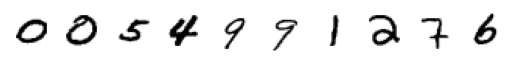

tensor([0, 0, 5, 4, 9, 9, 1, 2, 7, 6])

In [8]:
for idx in range(10):
    plt.subplot(1, 10, idx+1)
    plt.axis('off')
    plt.imshow(X[idx, :, :, :].reshape(28, 28), cmap='gray_r')
plt.show()
y[:10]

### 모델 만들기

In [9]:
# 모델 구조 설계

class MnistNet(nn.Module):
    # 여기서 층을 만들고 ( 모델 구조 설계 1 )
    def __init__(self):     # __init__ 초기화 함수. 
        super(MnistNet, self).__init__()    # 꼭 부모 클래스호출. 부모 클래스한테 내가 누군지 알려주기. 
        self.fc1 = nn.Linear(28*28, 512)    # fully connected = tonsorflow의 Dense. 입력 28*28, 출력 512
        self.fc2 = nn.Linear(512, 256)      # 앞의 출력이 지금의 입력, 출력 256
        self.fc3 = nn.Linear(256, 10)       # 마지막 출력층은 클래스 수와 같아야한다.
        pass
    # 여기서 층을 호출 ( 모델 구조 설계 2 )
    def forward(self, x):   # forward 여기서 모델 훈련. 그래서 입력데이터 받아주는 전달인자 필요
    # view는 numpy의 reshape과 유사. 기능만보면, tensorflow의 flattne(무조건 1차원으로 변환)과 유사. 
    # (view는 무조건 1차원으로 바꾸는건 아님)
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.relu(x)               # activation 지정: sigmoid, relu, selu, elu 등
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1) # dim=1: 손실함수 계산하는 방법 지정
        return x                    # 연산 끝난 x 받기
        pass

In [10]:
# 학습 도구 구성
model = MnistNet().to(device)
# loss = nn.CrossEntropyLoss()      # 카테고리 분류시 사용할 손실함수
criterion = nn.CrossEntropyLoss()     # torch 사용자들은 loss보다 criterion이라고 사용
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # learning late(lr) 기본값 0.001

print(model)

MnistNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [11]:
# 훈련 함수 정의 (학습 도구 기반 학습 설계) ( 함수 안 만들고 쭉 써도 된다. ) (tensorflow의 fit)
def train(model, train_loader, optimizer):
    model.train()   # train mode로 설정 > '지금부터 훈련이니까 가중치 업뎃 잘 해줘'라는 의미
    # 얘는 이 작업을 cpu에서 할지 gpu에서 할 지 알려줘야해
    # 모델이 gpu면 데이터도 gpu, 모델이 cpu면 데이터도 cpu
    for idx, (images, labels) in enumerate(train_loader):   # 훈련 log위해서 idx enumerate 설정
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()               # optimizer 초기화
        output = model(images)              # 모델이 학습할 images 주기
        loss = criterion(output, labels)    # 손실 계산을 위한 계산값과 실제값
        loss.backward()                     # 손실을 이용해서 기울기 계산(미분 작업 수행)
        optimizer.step()                    # optimizer가 가중치 업데이트 하라는 것

        if idx % 10 == 0:       # 10번에 한 번씩 log 남기기
            print(f'Batch : {idx}, Loss : {loss.item()}')

In [16]:
# 훈련 함수 정의 2 (배치 10으로 하니 너무 많아서 300으로 조정)
def train(model, train_loader, optimizer):
    model.train()
    for idx, (images, labels) in enumerate(train_loader):   # 훈련 log위해서 idx enumerate 설정
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()               # optimizer 초기화
        output = model(images)              # 모델이 학습할 images 주기
        loss = criterion(output, labels)    # 손실 계산을 위한 계산값과 실제값
        loss.backward()                     # 손실을 이용해서 기울기 계산(미분 작업 수행)
        optimizer.step()                    # optimizer가 가중치 업데이트 하라는 것

        if idx % 300 == 0:       # 10번에 한 번씩 log 남기기
            print(f'Batch : {idx}, Loss : {loss.item()}')

In [17]:
# 모델 평가 함수 정의
def evaluate(model, test_loader):
    loss_total = 0      # 전체 로스 한꺼번에 처리
    correct_total = 0
    model.eval()    # evaluation 모드로 설정 -> batch-normalization, drop-out 수행 중지
    with torch.no_grad():   # 가중치 업데이트 수행 중지 (기울기 계산 하지 마라)
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels).item() # item: tensor 안에 들어있는 값을 가져오기
            loss_total += loss
            predicted_values = output.max(1, keepdim=True)[1]   # output에서 max 1개 값만 가져오기
            correct = predicted_values.eq(labels.view_as(predicted_values)).sum().item() # 비교하기
            correct_total += correct
    
    loss_total /= (len(test_dataset) / 32 )
    # loss_total은 배치마다 나오므로, 전체 데이터셋을 배치사이즈로 나눈 값을 나눈 것
    accuracy = correct_total / len(test_dataset)
    # correct는 배치로 하지않고 전체로 했으므로 전체 개수로만 나눈다.

    return loss_total, accuracy

In [13]:
# 학습 실행

for epoch in range(10):
    train(model, train_loader, optimizer) 
    print(f"Epoch : {epoch}")

Batch : 0, Loss : 2.313100576400757
Batch : 10, Loss : 1.8756253719329834
Batch : 20, Loss : 1.3719195127487183
Batch : 30, Loss : 0.7485756278038025
Batch : 40, Loss : 0.7007478475570679
Batch : 50, Loss : 0.6945644021034241
Batch : 60, Loss : 0.5126047730445862
Batch : 70, Loss : 0.6539045572280884
Batch : 80, Loss : 0.3862488269805908
Batch : 90, Loss : 0.43053779006004333
Batch : 100, Loss : 0.28252342343330383
Batch : 110, Loss : 0.35779446363449097
Batch : 120, Loss : 0.35499492287635803
Batch : 130, Loss : 0.3869340717792511
Batch : 140, Loss : 0.2716469168663025
Batch : 150, Loss : 0.49868443608283997
Batch : 160, Loss : 0.4863290786743164
Batch : 170, Loss : 0.4904761016368866
Batch : 180, Loss : 0.19175484776496887
Batch : 190, Loss : 0.42203277349472046
Batch : 200, Loss : 0.3434264361858368
Batch : 210, Loss : 0.3815877139568329
Batch : 220, Loss : 0.23364000022411346
Batch : 230, Loss : 0.15688279271125793
Batch : 240, Loss : 0.18675777316093445
Batch : 250, Loss : 0.22775

In [18]:
# 학습 실행 2 

for epoch in range(10):
    train(model, train_loader, optimizer) 
    loss, accuracy = evaluate(model, test_loader)
    print(f"Epoch : {epoch + 1}, Loss : {loss}, Accuracy : {accuracy}")
    # 에폭마다 validation이 어떻게 개선되는지 볼 수 있게 함. (여기선 validation따로 안 만들어서 test로 함)

Batch : 0, Loss : 0.0018219816265627742
Batch : 300, Loss : 8.903377306523907e-07
Batch : 600, Loss : 0.0006543801864609122
Batch : 900, Loss : 0.013878362253308296
Batch : 1200, Loss : 0.0002619125007186085
Batch : 1500, Loss : 4.65810953755863e-05
Batch : 1800, Loss : 0.0020407382398843765
Epoch : 1,Loss : 0.09409048724945478, Accuracy : 0.9818
Batch : 0, Loss : 0.0007513491436839104
Batch : 300, Loss : 1.739691697366652e-06
Batch : 600, Loss : 2.280044100189116e-05
Batch : 900, Loss : 1.359184261673363e-05
Batch : 1200, Loss : 7.513464879593812e-06
Batch : 1500, Loss : 0.0020486980210989714
Batch : 1800, Loss : 0.055650874972343445
Epoch : 2,Loss : 0.09745687970563136, Accuracy : 0.9789
Batch : 0, Loss : 0.0024067761842161417
Batch : 300, Loss : 4.95124222652521e-05
Batch : 600, Loss : 0.00044819802860729396
Batch : 900, Loss : 0.00019656532094813883
Batch : 1200, Loss : 9.728407894726843e-05
Batch : 1500, Loss : 0.00010791745444294065
Batch : 1800, Loss : 6.7574505919765215e-06
Epo

In [19]:
# 최정적인 작업
evaluate(model, test_loader)
# (0.10986950756961578, 정확도 : 0.9776)
# (0.13539811854153214, 0.9812)

(0.13539811854153214, 0.9812)